In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from PIL import Image
import pandas as pd
import numpy as np
import glob
import os

# Function to return data in 2D numpy array and training labels


In [2]:
def data_and_labels(path):
    
    image_list = []
    for filename in glob.glob(path + '*.gif'):
        im=Image.open(filename)
        image_list.append(im)
    
    data = [0]*len(image_list)
    for i,image in enumerate(image_list):
        data[i] = np.array(image)
    
    data = np.array(data) # Contains the image data as numpy array
    
    names = os.listdir(path)
    
    labels = []
    
    #### 1: Happy
    #### 0: Sad
    
    for name in names:
        if 'happy' in name:
            labels.append(1) 
        elif 'sad' in name:
            labels.append(0)
        
    labels = np.array(labels) # Contains the class labels as numpy array
        
    return data, labels
    

# Function to perform PCA and LDA to reduce to one dimenson

In [3]:
def pca_lda_1(data, labels, d):
    
    N, D = data.shape[0], data.shape[1]
    
    X = data.reshape(N,D*D) # Matrix flattening operation
    mean = np.mean(X,axis=0)
    X = X-mean # Obtaining the centered data
    
    # cov_mod is the modified covariance matrix given by X*X.T
    cov_mod = X@X.T
    cov_mod = cov_mod/N
    
    eigvals, eigvecs = eigh(cov_mod)
    
    # Reversing order of arrays to represent greatest to smallest values
    eigvals = eigvals[::-1]
    v = eigvecs[::-1]
    
    # Removing last entry from eigenvalues and eigenvectors as they can give zero division error
    eigvals = eigvals[:-1]
    v = v[:-1]
    
    # Slicing v to meed the desired number of principal components (d<=19)
    
    v = v[0:d]
    
    # Computing u from v
    
    u = []
    for i, vector in enumerate(v):
        u.append(X.T@(vector/((N*eigvals[i])**0.5)))
        
    u = np.array(u)
    
    # Multiplying sample data with u to get data with reduced dimensionality
    
    sample_data = data.reshape(N,D*D)
    
    y = np.matmul(u, sample_data.T)
    
    # Stacking the data into Pandas data frame for ease of manipulation and fast manipulation
    
    pca_data = np.vstack((y, labels)).T
    
    df = pd.DataFrame(data = pca_data)
    
    Sw = np.zeros((d,d))
    
    unique_labels = np.unique(labels)
    
    # Class wise operation to create within variance matrix
    means =[]
    
    for c in unique_labels:
        Xc = df[df[d]==c].iloc[:,0:d]
        samples = Xc.shape[0]
        mean_c = np.mean(Xc.iloc[:,0:d], axis = 0)
        means.append(mean_c)
        Sw += ((Xc-mean_c).T.dot(Xc-mean_c))/samples
        
    means = np.array(means)
    mean_diff = (means[0]-means[1]).reshape(d,1)
    
    lda_multiplier = np.linalg.inv(Sw)@(means[0]-means[1]) # Multiplier matrix to give data with reduced dimensionality of one
    
    output  = df.iloc[:,:d]@lda_multiplier # Storing training output for subsequent operation
    
    
    return u, lda_multiplier, output


In [4]:
def find_threshold(output, labels):
    
    plotter = np.vstack((output, labels)).T
    
    x1 = [] # Stores values of Sad faces
    x0 = [] # Stores values for Happpy faces
    
    for data in plotter:
        if (data[1]==1):
            x1.append(data[0])
        
        elif (data[1]==0):
            x0.append(data[0])
    
    threshold = (max(x1)+min(x0))/2 # Threshold for classification
    
    return x1, x0, threshold

In [5]:
def plot_LDA(x1, x0, threshold):
    
    x1_error, x0_error = 0, 0
    
    ### ERRORS IN 1:Happy
    
    for x in x1:
        if (x>threshold):
            x1_error = x1_error + 1
    
    ### ERRORS IN 0:Sad
    
    for x in x0:
        if(x<threshold):
            x0_error = x0_error + 1
            
    accuracy = (1 - ((x1_error+x0_error)/(len(x1)+len(x0))))*100
    
    print("Accuracy = ", accuracy, "%")
    print("Threshold (X) = ", threshold)
    
    y1 = [0]*len(x1)
    y0 = [0]*len(x0)
    
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(5)
    
    # Green represents Happy while blue represents Sad
    plt.scatter(x1,y1,c="green", label = 'Happy')
    plt.scatter(x0,y0,c="blue", label = 'Sad')
    plt.axvline(x = threshold, color = 'black') # Plotting the threshold
    plt.text(threshold + 1, 0.03, 'SAD ->', fontsize = 12, color = 'blue')
    plt.text(threshold - 3, 0.03, '<- HAPPY', fontsize = 12, color = 'green')
    plt.legend()
    plt.show()
    

# Function to obtain parameters & return training results

In [6]:
def model_training(path, d):
    
    ## INPUTS: Path, 'd' - Desired number of Reduced Dimensions
    
    ## RETURNS: Trained U Matrix, Trained LDA Multiplier, Trained value of Classification Threshold
    

    train_data, train_labels = data_and_labels(path)

    trained_u, trained_lda_multiplier, train_output = pca_lda_1(train_data, train_labels, d)

    x1, x0, trained_threshold = find_threshold(train_output, train_labels)
    
    plot_LDA(x1, x0, trained_threshold)
    
    return trained_u, trained_lda_multiplier, trained_threshold

# Function to fit trained parameters onto test data

In [7]:
def model_testing(path, trained_u, trained_lda_multiplier, trained_threshold):
    
    ## INPUTS: Path, Trained U Matrix, Trained LDA Multiplier, Trained value of Classification Threshold
    
    ## RETURNS: Plot on 1D & Testing Accuracy
    
    
    test_data, test_labels = data_and_labels(path)

    test_data = test_data.reshape(test_data.shape[0],test_data.shape[1]*test_data.shape[2])

    pca_on_test = np.matmul(trained_u, test_data.T)

    lda_on_test = pca_on_test.T@trained_lda_multiplier
    
    plotter = np.vstack((lda_on_test, test_labels)).T
    
    x1 = [] # Stores values of Sad faces
    x0 = [] # Stores values for Happpy faces
    
    for data in plotter:
        if (data[1]==1):
            x1.append(data[0])
        
        elif (data[1]==0):
            x0.append(data[0])
    
    plot_LDA(x1, x0, trained_threshold)
    
    

# Training the model

Accuracy =  100.0 %
Threshold (X) =  -4.433774774937715


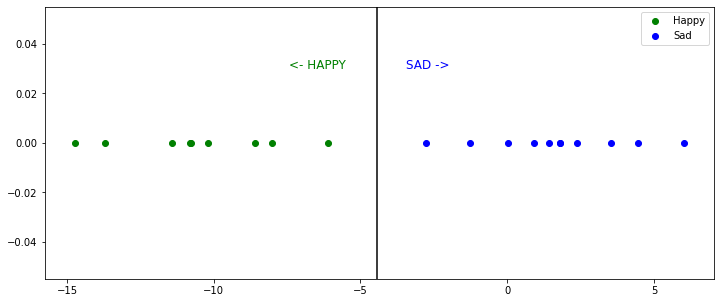

In [8]:
path = 'Data_Q4/emotion_classification/train/'
K = 16 ####### 'd' HAS TO BE LESS THAN OR EQUAL TO 19
trained_u, trained_lda_multiplier, trained_threshold = model_training(path, K)

# Values beyond - 4.4337 are classified as Happy
# Values above - 4.4337 are classified as Sad

# On training for d>=18, we observe that all negative values are classified as Happy and positive as Sad; indicating of a 
# signum type classification possibility

# Testing the model on the test data

Accuracy =  90.0 %
Threshold (X) =  -4.433774774937715


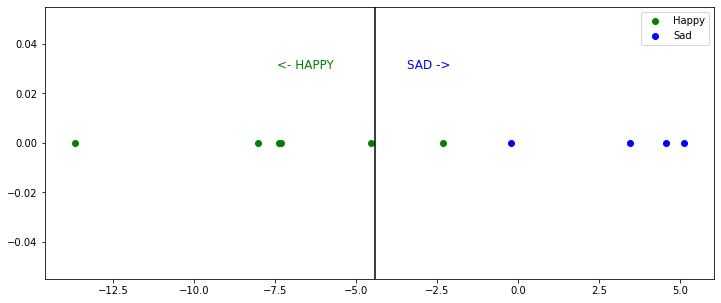

In [9]:
path = 'Data_Q4/emotion_classification/test/'
model_testing(path, trained_u, trained_lda_multiplier, trained_threshold)

# Best accuracy obtained is 90%. This value persists even for K = 19 (max possible K).

## Hence, the minimum value of K for which we observe best accuracy and thus maximum separabiliy is *16*. Higher values of K aare giving the same accuracy score.